<a href="https://colab.research.google.com/github/MichelleAppel/distribution-aware-image-to-image-translation/blob/master/toy_examples/Fly_VAE_anno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### imports



In [77]:
import os.path
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms

from itertools import chain

import numpy as np
import math
import itertools
import random

from scipy import signal

import matplotlib.pyplot as plt

import zipfile

from sklearn.manifold import TSNE

import pickle

# Fly data experiment

Todo:
*   Use annotations somehow for evaluation of distribution net

## The Fly dataset

In [78]:
zipdataroot_A = '/content/drive/MyDrive/fly_data_ubc_2021/generated_fly_with_annotation.zip'
zipdataroot_B = '/content/drive/MyDrive/fly_data_ubc_2021/real_fly.zip'

dataroot_A = '/content/flydata/data_A'
dataroot_B = '/content/flydata/data_B'

if not os.path.exists(dataroot_A):
  with zipfile.ZipFile(zipdataroot_A, 'r') as zip_ref:
      zip_ref.extractall(dataroot_A)

if not os.path.exists(dataroot_B):
  with zipfile.ZipFile(zipdataroot_B, 'r') as zip_ref:
      zip_ref.extractall(dataroot_B)

In [79]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def make_dataset(dir):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname) and not fname.endswith('real_A.png') and not fname.endswith('render_pose.png'):
                path = os.path.join(root, fname)
                images.append(path)

    return images

In [80]:
def __adjust(img):
    ow, oh = img.size

    # the size needs to be a multiple of this number,
    # because going through generator network may change img size
    # and eventually cause size mismatch error
    mult = 4
    if ow % mult == 0 and oh % mult == 0:
        return img
    w = (ow - 1) // mult
    w = (w + 1) * mult
    h = (oh - 1) // mult
    h = (h + 1) * mult

    return img.resize((w, h), Image.BICUBIC)

def normalize(img):
  return img * 2 - 1


def get_transform():
    loadSize = 128
    osize = [loadSize, loadSize]

    transform_list = []
    transform_list.append(transforms.Lambda(
            lambda img: __adjust(img)))
    
    transform_list.append(transforms.Resize(osize, Image.BICUBIC))  
    transform_list += [transforms.ToTensor()]
                      #  transforms.Normalize((0.5, 0.5, 0.5),
                      #                       (0.5, 0.5, 0.5))]
    transform_list.append(transforms.Lambda(
            lambda img: normalize(img)))
    
    return transforms.Compose(transform_list)

In [81]:
class FlyDataset(Dataset):
  def __init__(self, annotated = False):
    self.annotated = annotated

    self.dataroot_A = dataroot_A
    if self.annotated:
      self.dataroot_B = os.path.join(dataroot_B, 'real_fly_with_annotations')
    else:
      self.dataroot_B = os.path.join(dataroot_B, 'real_fly_without_annotations')

    self.A_paths = make_dataset(self.dataroot_A)
    self.B_paths = make_dataset(self.dataroot_B)

    self.A_size = len(self.A_paths)
    self.B_size = len(self.B_paths)

    self.dir_len = len(self.dataroot_A) + 1

    self.transform = get_transform()

    if self.annotated:
      self.annotation_A = pickle.load(open(os.path.join(self.dataroot_A, 'test_14_14', 'target_anno.pth' ),'rb'))
      self.annotation_B = pickle.load(open(os.path.join(self.dataroot_B, 'test_anno.pth' ),'rb'))

  def __getitem__(self, index):
      A_path = self.A_paths[index % self.A_size]
      A_name = A_path[self.dir_len:]

      index_B = random.randint(0, self.B_size - 1)
      B_path = self.B_paths[index_B]

      A_img = Image.open(A_path).convert('RGB')
      B_img = Image.open(B_path).convert('RGB')

      A = self.transform(A_img)
      B = self.transform(B_img)

      if self.annotated:
        annotation_A = torch.Tensor(self.annotation_A[A_path.split('/')[-1]])
        annotation_B = torch.Tensor(self.annotation_B[B_path.split('/')[-1]])
        return {'A': A, 'pose_A': annotation_A, 'B': B, 'pose_A': annotation_B}
      else:
        return {'A': A, 'B': B}


  def __len__(self):
    return max(self.A_size, self.B_size)

In [82]:
def visualize(img):
  plt.imshow((img.permute(1,2,0) + 1) / 2)
  plt.show()

## The VAE network

We use a VAE to encode the latent space of the fly images. The latent space of a VAE is structued as a distribution with mean $\mu$ and variance $\sigma$. This distribution is later used to determine the frequency of the samples with our distribution net.

In [83]:
# VAE code from https://github.com/podgorskiy/VAE

class VAE(nn.Module):
    def __init__(self, zsize, layer_count=5, channels=3):
        super(VAE, self).__init__()

        d = 128
        self.d = d
        self.zsize = zsize

        self.layer_count = layer_count

        mul = 1
        inputs = channels
        for i in range(self.layer_count):
            setattr(self, "conv%d" % (i + 1), nn.Conv2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "conv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul *= 2

        self.d_max = inputs

        self.fc1 = nn.Linear(inputs * 4 * 4, zsize)
        self.fc2 = nn.Linear(inputs * 4 * 4, zsize)

        self.d1 = nn.Linear(zsize, inputs * 4 * 4)

        mul = inputs // d // 2

        for i in range(1, self.layer_count):
            setattr(self, "deconv%d" % (i + 1), nn.ConvTranspose2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "deconv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul //= 2

        setattr(self, "deconv%d" % (self.layer_count + 1), nn.ConvTranspose2d(inputs, channels, 4, 2, 1))

    def encode(self, x):
        for i in range(self.layer_count):
            x = F.relu(getattr(self, "conv%d_bn" % (i + 1))(getattr(self, "conv%d" % (i + 1))(x)))

        x = x.view(x.shape[0], self.d_max * 4 * 4)
        h1 = self.fc1(x)
        h2 = self.fc2(x)
        return h1, h2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, x):
        x = x.view(x.shape[0], self.zsize)
        x = self.d1(x)
        x = x.view(x.shape[0], self.d_max, 4, 4)
        #x = self.deconv1_bn(x)
        x = F.leaky_relu(x, 0.2)

        for i in range(1, self.layer_count):
            x = F.leaky_relu(getattr(self, "deconv%d_bn" % (i + 1))(getattr(self, "deconv%d" % (i + 1))(x)), 0.2)

        x = F.tanh(getattr(self, "deconv%d" % (self.layer_count + 1))(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        mu = mu.squeeze()
        logvar = logvar.squeeze()
        z = self.reparameterize(mu, logvar)
        return self.decode(z.view(-1, self.zsize, 1, 1)), mu, logvar

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)


def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

## Training the VAE

We first train the VAE first to establish translation to the latent space.

In [84]:
dataset = FlyDataset(annotated=False)

batch_size = 32
dataloader = DataLoader(dataset, batch_size, shuffle=True)

In [85]:
def loss_function(recon_x, x, mu, logvar):
    BCE = torch.mean((recon_x - x)**2)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(torch.mean(1 + logvar - mu.pow(2) - logvar.exp(), 1))
    return BCE, KLD * 0.1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 0 step 0 loss_re_AB 1.1463329792022705 loss_kl_AB 0.012852239422500134


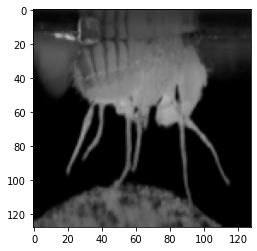

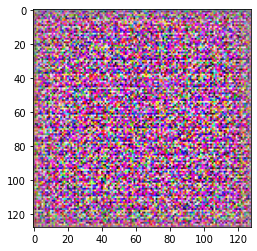

KeyboardInterrupt: ignored

In [86]:
# Initialize the network
vae = VAE(zsize=512).cuda()

# Initialize the optimizers
lr = 0.0005
vae_optimizer = optim.Adam(vae.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-5)
train_epoch = 40

# For storing results
rec_loss_AB = []
kl_loss_AB  = []

for epoch in range(train_epoch):
    vae.train() # Training mode

    if (epoch + 1) % 8 == 0: # Adaptive learning rate
        vae_optimizer.param_groups[0]['lr'] /= 4
        print("learning rate change!")

    for i, data in enumerate(dataloader):
        vae.zero_grad()
        
        img_A = data['A'].cuda()
        img_B = data['B'].cuda()
        img_AB = torch.cat((img_A, img_B))

        # The embeddings
        rec_AB, mu_AB, logvar_AB = vae(img_AB)

        # The loss function --------------------------------------------------------------------------------
        loss_re_AB, loss_kl_AB = loss_function(rec_AB, img_AB, mu_AB, logvar_AB)

        # Backward -----------------------------------------------------------------------------------------
        (loss_re_AB + loss_kl_AB).backward()
        vae_optimizer.step()

        # Store values -------------------------------------------------------------------------------------
        rec_loss_AB += [loss_re_AB.item()]
        kl_loss_AB += [loss_kl_AB.item()]

        # --------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 10 == 0:
            print('epoch', epoch, 'step', i,
                  'loss_re_AB', loss_re_AB.item(), 'loss_kl_AB', loss_kl_AB.item())

        if i % 50 == 0: # Visualize output now and then
            visualize(img_AB[0].cpu())
            visualize(rec_AB[0].detach().cpu())

## Results of the VAE training

In [ ]:
def smooth(list):
  return signal.savgol_filter(list, 101, 3)

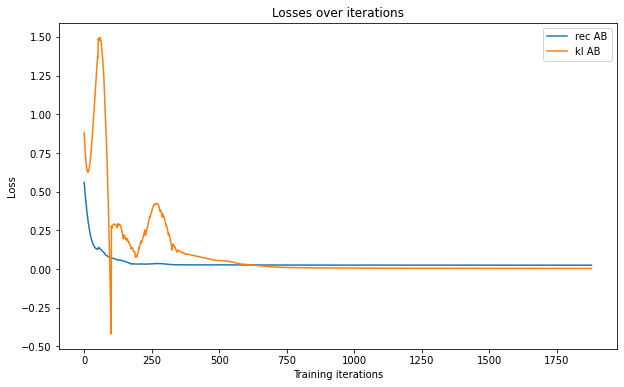

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(smooth(rec_loss_AB))
plt.plot(smooth(kl_loss_AB))
plt.legend(['rec AB', 'kl AB'])
plt.show()

## VAE latent space analyzation

Training of the VAE takes a while. This way you can load a saved model.

In [89]:
# Save model
# torch.save(vae.state_dict(), '/content/vae_AB')

# Load model
vae = VAE(zsize=512).cuda()
vae.load_state_dict(torch.load('/content/vae_AB'))
vae.eval()

RuntimeError: ignored

We are about to visualize the latent representation of the entire dataset. Since the GPU space is limited, the dataset is loaded and fed to the network in batches.

In [ ]:
batch_size = 32
dataloader_all = DataLoader(dataset, batch_size, shuffle=True)

recs_AB = ()
mus_AB = ()
vars_AB = ()

for i, data in enumerate(dataloader_all):
  data_AB = torch.cat((data['A'], data['B']))
  rec_AB, mu_AB, var_AB = vae(data_AB.cuda())
  recs_AB += (rec_AB.detach().cpu(), )
  mus_AB += (mu_AB.detach().cpu(), )
  vars_AB += (var_AB.detach().cpu(), )

recs_AB = torch.cat(recs_AB)
mus_AB = torch.cat(mus_AB)
vars_AB = torch.cat(vars_AB)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [ ]:
def visualize_grid(img):
  plt.figure(figsize=(15,15))
  plt.imshow((img.permute(1,2,0) + 1) / 2)
  plt.axis('off')
  plt.show()

First, lets take a look at the produced reconstructions. The reconstruction of the poses of the fly is concerning, since it appears blurred and all reconstructions look similar.

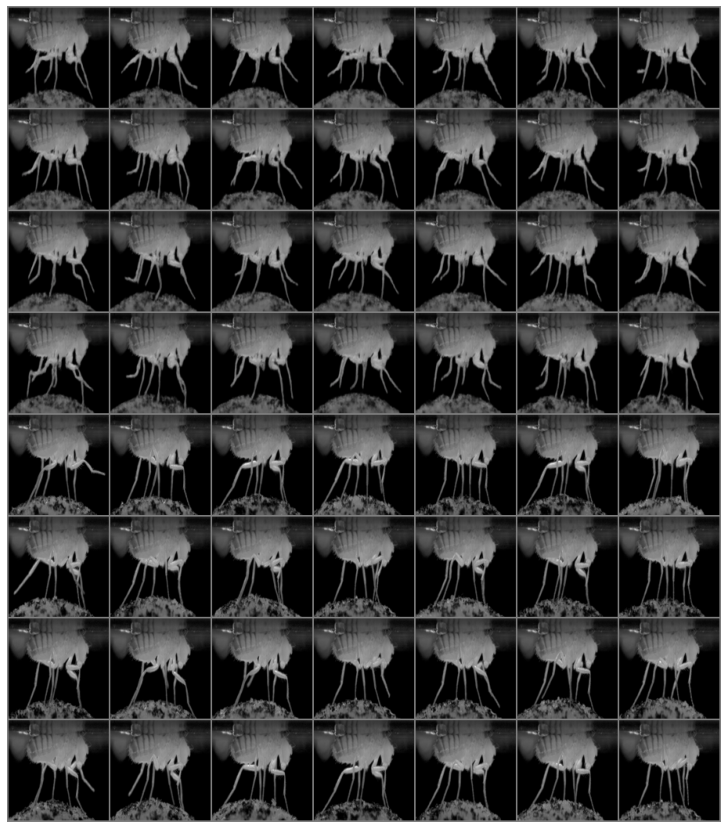

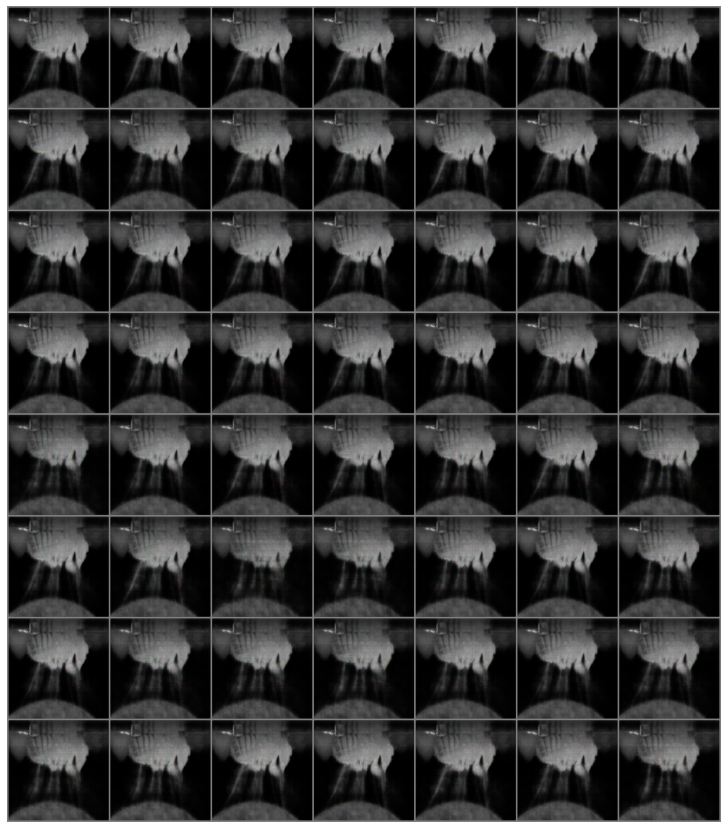

In [ ]:
visualize_grid(make_grid(data_AB, nrow=7))
visualize_grid(make_grid(rec_AB.detach().cpu(), nrow=7))

In [ ]:
# Perform t-SNE embedding
embedded_mu = TSNE(n_components=2).fit_transform(mus_AB.detach().cpu())
embedded_var = TSNE(n_components=2).fit_transform(vars_AB.detach().cpu())

In [ ]:
# Get the right labels
idx = torch.zeros(3000, dtype=torch.uint8)
for i in range(94):
  if i % 2 == 0:
    idx[32*i:32*(i+1)] = 1
  
idx_A = idx==1
idx_B = idx==0

Even though the reconstructed images look not that different from one another, we can see a difference in the latent space representation between real and fake images. This means that distribution net should be able to learn the difference in distribtion of the domains.

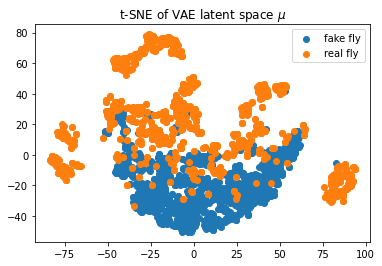

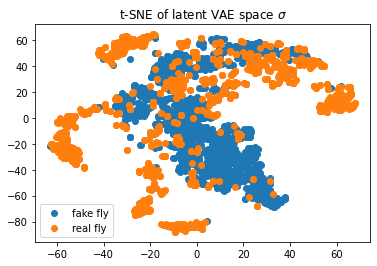

In [ ]:
plt.title('t-SNE of VAE latent space $\mu$')
plt.scatter(embedded_mu[idx_A, 0], embedded_mu[idx_A, 1])
plt.scatter(embedded_mu[idx_B, 0], embedded_mu[idx_B, 1])
plt.legend(['fake fly', 'real fly'])
plt.show()

plt.title('t-SNE of latent VAE space $\sigma$')
plt.scatter(embedded_var[idx_A, 0], embedded_var[idx_A, 1])
plt.scatter(embedded_var[idx_B, 0], embedded_var[idx_B, 1])
plt.legend(['fake fly', 'real fly'])
plt.show()

## Annotations

In [102]:
dataset = FlyDataset(annotated=True)

annotation_A = torch.Tensor(list(dataset.annotation_A.values()))
annotation_B = torch.Tensor(list(dataset.annotation_B.values()))

In [115]:
# Perform t-SNE embedding
embedded_poses = TSNE(n_components=2).fit_transform(annotation_A.view(-1,60))

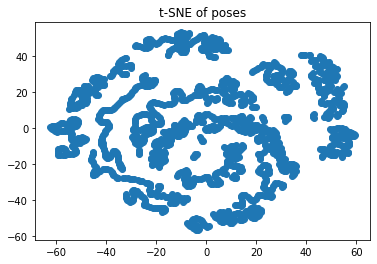

In [118]:
plt.title('t-SNE of poses')
plt.scatter(embedded_poses[:, 0], embedded_poses[:, 1])
plt.show()

## Distribution network

In [ ]:
class DistributionNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(DistributionNet, self).__init__()
        self.softmax = nn.Softmax(dim=0)

        self.conv1 = nn.Conv2d(3, 10, kernel_size=7)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 40, kernel_size=5)
        self.fc1 = nn.Linear(40*12*12, 40)
        self.fc2 = nn.Linear(40, 1)
        
    def forward(self, x):
        h1 = torch.sigmoid(F.max_pool2d(self.conv1(x), 2))
        h2 = torch.sigmoid(F.max_pool2d(self.conv2(h1), 2))
        h3 = torch.sigmoid(F.max_pool2d(self.conv3(h2), 2))
        h4 = h3.view(-1, 40*12*12)
        h5 = torch.sigmoid(self.fc1(h4))
        out = self.fc2(h5)
        return self.softmax(out), out

In [ ]:
def n_centered_moment(x, w, n):
  if n > 1:
    c = n_centered_moment(x, w, 1)
  else:
    c = 0
  return (((x - c)**n)*w).sum(0)

## Training of distribution net

The goal of this network is to predict the relative frequency of samples.

Todo:
* Think about how we can use the latent space $\mu$, $\sigma$ in a way that makes sense. For now I used the first centered moment of $\mu_z$ as a loss function for the Distribution net. Maybe we should consider using KL-divergence in this sense.

In [ ]:
# Initialize the networks
distribution_network = DistributionNet().cuda()
# Initialize the optimizers
lr = 0.01
optimizer_d = optim.Adam(distribution_network.parameters(), lr=lr)

criterion_d = nn.MSELoss()

# For storing results
losses_d = []

means_A = []
means_B = []

vars_A = []
vars_B = []

moments_A = []
moments_B = []

example_importances_A = []

n = 1 # n-centered moment

vae.eval()

for epoch in range(5):
    for i, data in enumerate(dataloader):
        
        img_A = data['A'].cuda()
        img_B = data['B'].cuda()

        # The embeddings
        rec_A, mu_A, logvar_A = vae(img_A)
        rec_B, mu_B, logvar_B = vae(img_B)

        # The weighting process
        w_A = distribution_network(img_A)[0]
        w_B = 1/len(img_B)

        # The loss function --------------------------------------------------------------------------------
        n_centered_moment_A_mu = n_centered_moment(mu_A.detach(), w_A, n)
        n_centered_moment_B_mu = n_centered_moment(mu_B.detach(), w_B, n)
        # n_centered_moment_A_var = n_centered_moment(var_A.detach(), w_A, n)
        # n_centered_moment_B_var = n_centered_moment(var_B.detach(), w_B, n)
        loss_d = criterion_d(n_centered_moment_A_mu, n_centered_moment_B_mu)

        # ---------------------------------------------------------------------------------------------------

        # Backward
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step() 

        # Store values --------------------------------------------------------------------------------------
        moments_A += [n_centered_moment_A_mu.cpu().detach().numpy()]
        moments_B += [n_centered_moment_B_mu.cpu().detach().numpy()]

        means_A += [n_centered_moment(mu_A, w_A, 1).detach().cpu().numpy()]
        means_B += [n_centered_moment(mu_B, w_B, 1).detach().cpu().numpy()]

        vars_A += [n_centered_moment(mu_A, w_A, 2).detach().cpu().numpy()]
        vars_B += [n_centered_moment(mu_B, w_B, 2).detach().cpu().numpy()]    

        losses_d += [loss_d.item()]

        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 10 == 0:
            print('epoch', epoch, 'step', i, 'loss_d: ', loss_d.item())
            
        if i % 10000 == 0 and i != 0:
            break

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 0 step 0 loss_d:  0.0061888438649475574
epoch 0 step 10 loss_d:  0.0010240559931844473
epoch 0 step 20 loss_d:  0.0013653308851644397
epoch 0 step 30 loss_d:  0.005462932400405407
epoch 0 step 40 loss_d:  0.005058125592768192
epoch 1 step 0 loss_d:  0.0025409110821783543
epoch 1 step 10 loss_d:  0.002925956854596734
epoch 1 step 20 loss_d:  0.003972532227635384
epoch 1 step 30 loss_d:  0.0020069098100066185
epoch 1 step 40 loss_d:  0.0021832918282598257
epoch 2 step 0 loss_d:  0.0037471121177077293
epoch 2 step 10 loss_d:  0.001686361152678728
epoch 2 step 20 loss_d:  0.0008255240973085165
epoch 2 step 30 loss_d:  0.0015809787437319756
epoch 2 step 40 loss_d:  0.0021894616074860096
epoch 3 step 0 loss_d:  0.0012726220302283764
epoch 3 step 10 loss_d:  0.0006478755967691541
epoch 3 step 20 loss_d:  0.002306347945705056
epoch 3 step 30 loss_d:  0.0015644498635083437
epoch 3 step 40 loss_d:  0.0009163023787550628
epoch 4 step 0 loss_d:  0.0019025977235287428
epoch 4 step 10 loss_d: 

In [ ]:
moments_A = torch.Tensor(moments_A)
moments_B = torch.Tensor(moments_B)
means_A = torch.Tensor(means_A)
means_B = torch.Tensor(means_B)
vars_A = torch.Tensor(vars_A)
vars_B = torch.Tensor(vars_B)

## Results of distribution net

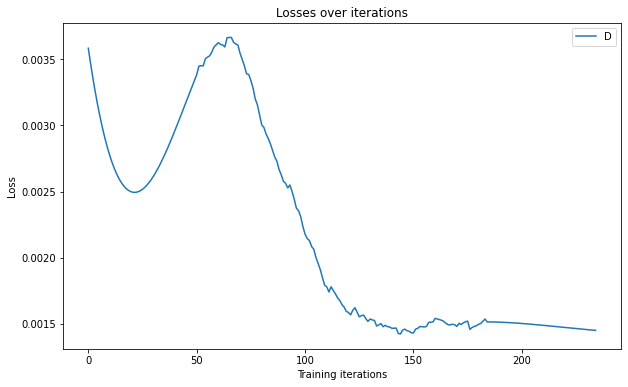

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
smoothed_losses_d = signal.savgol_filter(losses_d,101,3)
plt.plot(smoothed_losses_d)
plt.legend(['D'])
plt.show()

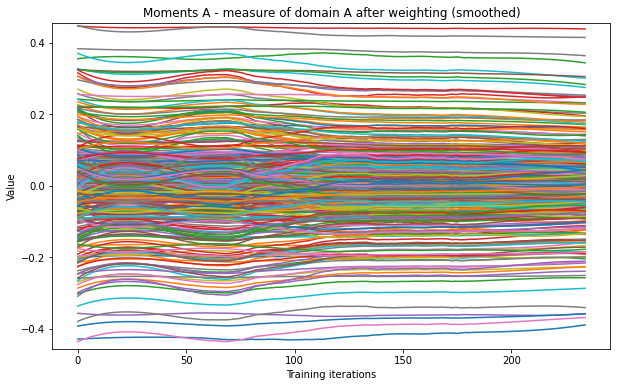

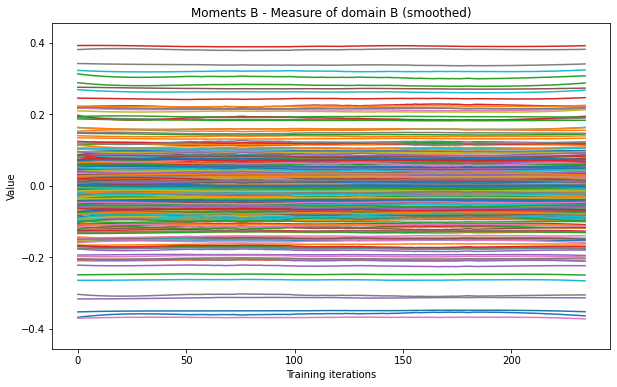

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Moments A - measure of domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Value')
plt.ylim(ymax = moments_A.max(), ymin = moments_A.min())
smoothed_Lmin = signal.savgol_filter(moments_A,101,3,axis=0)
plt.plot(smoothed_Lmin)
# plt.legend(np.arange(len(moments_A[0])))
plt.show()

plt.figure(figsize=(10,6))
plt.title('Moments B - Measure of domain B (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Value')
plt.ylim(ymax = moments_A.max(), ymin = moments_A.min())
smoothed_Lplus = signal.savgol_filter(moments_B,101,3,axis=0)
plt.plot(smoothed_Lplus)
# plt.legend(np.arange(len(moments_A[0])))
plt.show()

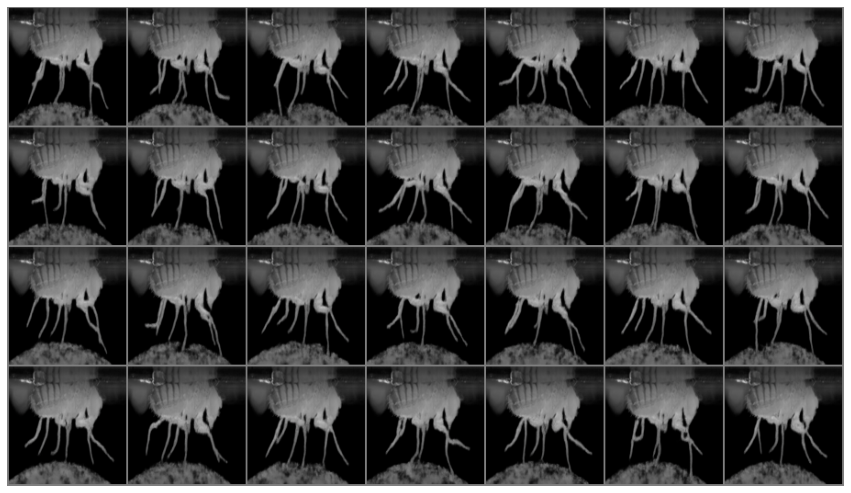

0 0.11436392366886139
1 0.24541275203227997
2 0.06121585890650749
3 0.10946418344974518
4 0.523236095905304
5 2.645958185195923
6 0.13002485036849976
7 3.075347661972046
8 7.9673051834106445
9 0.16809387505054474
10 0.04168659448623657
11 0.013609842397272587
12 0.18631426990032196
13 0.12525606155395508
14 0.6357713341712952
15 0.07317134737968445
16 0.15297594666481018
17 5.7577385902404785
18 0.09882937371730804
19 0.2823009788990021
20 0.33807727694511414
21 3.1191649436950684
22 0.04247608035802841
23 1.1985687017440796
24 0.16238154470920563
25 0.19868777692317963
26 0.34430819749832153
27 0.18825913965702057


In [ ]:
# These are generated images
weights = distribution_network(img_A)[0]
weights *= len(weights)

visualize_grid(make_grid(img_A.cpu(), nrow=7))

for i, weight in enumerate(weights):
  print(i, weight.item())